In [126]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc
import seaborn as sns
import sys

# sys.path.append("/home/icb/giovanni.palla/code/spatial-alignment/data")
# from data.simulated.generate_twod_data import generate_twod_data_partial_overlap

%load_ext autoreload
%autoreload 2
%load_ext lab_black

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [127]:
adata = sc.read(
    "/lustre/groups/ml01/workspace/giovanni.palla/moscot/data/alignment.h5ad"
)

adata = adata[adata.obs.synth_batch == "6"].copy()
sc.pp.subsample(adata, fraction=0.8)
adata

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


AnnData object with n_obs × n_vars = 640 × 500
    obs: 'batch', 'idx', 'synth_batch'
    obsm: 'spatial'

In [128]:
from moscot.problems.space._alignment import SpatialAlignmentProblem
from moscot.backends.ott import FGWSolver, SinkhornSolver, GWSolver

prob = SpatialAlignmentProblem(adata)
prob.prepare(key="batch")

In [129]:
prob = prob.solve(epsilon=1e-3)

/mnt/home/icb/giovanni.palla/code/moscot/moscot/solvers/_utils.py:26: UserWarning: Source marginals are not satisfied within rtol=0.001, atol=0.001.
  warnings.warn(msg)
/mnt/home/icb/giovanni.palla/code/moscot/moscot/solvers/_utils.py:26: UserWarning: Target marginals are not satisfied within rtol=0.001, atol=0.001.
  warnings.warn(msg)


In [130]:
ad1 = adata[adata.obs.batch == 0].copy()
ad2 = adata[adata.obs.batch == 1].copy()

In [131]:
prob.solution

{(0, 1): <moscot.problems._base_problem.GeneralProblem at 0x7f7fe1ebac70>}

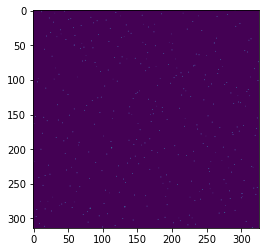

In [132]:
import seaborn as sns

k = (0, 1)
p = prob.solution[k].solution.transport_matrix
plt.imshow(p)

In [133]:
X = ad2.obsm["spatial"]
p = prob.solution[k].solution.transport_matrix
p = p / p.sum(1)[:, None]

Y = ad2.obsm["spatial"].T @ p.T
Y = Y.T
Y.shape

(314, 2)

In [134]:
adata.obsm["spatial_aligned"] = np.vstack([Y, X])

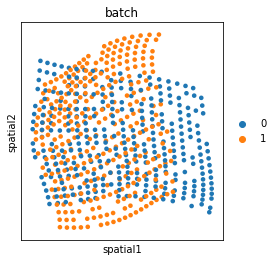

In [135]:
sc.pl.spatial(adata, spot_size=0.1, color="batch")

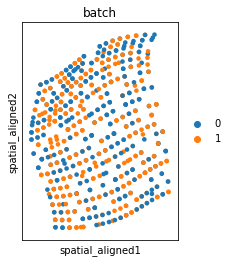

In [136]:
sc.pl.spatial(adata, basis="spatial_aligned", spot_size=0.1, color="batch")

In [137]:
from sklearn.metrics import mean_squared_error

ad1 = adata[adata.obs.batch == 0].copy()
ad2 = adata[adata.obs.batch == 1].copy()
inter, comm1, comm2 = np.intersect1d(ad1.obs.idx, ad2.obs.idx, return_indices=True)
mean_squared_error(ad1.obsm["spatial"][comm1], ad2.obsm["spatial"][comm1])

2.0742730430880907

In [113]:
ad1 = adata[adata.obs.batch == 0].copy()
ad2 = adata[adata.obs.batch == 1].copy()

In [115]:
ad1.obs.idx

299-2    299
303-2    303
40-6      40
236-2    236
389-2    389
        ... 
117-6    117
25-6      25
110-6    110
149-6    149
152-6    152
Name: idx, Length: 314, dtype: int64

In [123]:
ad1.obs.idx[comm1]

0-6        0
1-6        1
2-6        2
3-6        3
4-6        4
        ... 
393-2    393
394-2    394
395-2    395
397-2    397
399-2    399
Name: idx, Length: 259, dtype: int64

In [125]:
ad2.obs.idx[comm2]

400-2      0
401-2      1
402-2      2
403-2      3
404-2      4
        ... 
793-2    393
794-2    394
795-2    395
797-2    397
799-2    399
Name: idx, Length: 259, dtype: int64

In [114]:
ad1.obsm["spatial_aligned"]

array([[ 1.82771075e+00,  1.85119882e-01],
       [-1.81588507e+00, -1.51819301e+00],
       [ 1.37323594e+00, -8.46578777e-02],
       [ 9.80221629e-01, -1.94116664e+00],
       [-4.31347072e-01, -1.62631845e+00],
       [ 1.07828021e+00, -1.55442953e+00],
       [-8.00529301e-01,  1.24894130e+00],
       [-1.44107544e+00,  2.10595354e-01],
       [ 1.24319196e+00, -6.55448556e-01],
       [-3.07993710e-01,  3.92300814e-01],
       [-9.99623239e-01, -1.18308604e+00],
       [-2.64183164e-01,  5.93159556e-01],
       [ 5.62733829e-01, -1.75318050e+00],
       [ 1.55894792e+00,  3.98316495e-02],
       [-9.29138243e-01, -6.11815572e-01],
       [ 2.96830535e-01,  9.88934636e-02],
       [-1.52939272e+00, -1.81556022e+00],
       [ 1.71797597e+00, -1.17954338e+00],
       [ 5.46831906e-01,  2.32141063e-01],
       [ 3.43639970e-01,  2.79016346e-01],
       [ 1.78124392e+00, -1.70744765e+00],
       [ 3.56883928e-02, -1.88933527e+00],
       [-2.93138444e-01, -1.36955583e+00],
       [ 9.

In [148]:
k = list(prob.solution.keys())[0]
prob.solution[k].solution.transport_matrix.shape

(89, 91)

In [46]:
def generalized_procrustes_analysis_2D(X, Y, pi, output_params=True):
    """
    Finds and applies optimal rotation between spatial coordinates of two slices in 2D and returns the rotation angle and translation.

    param: X - np array of spatial coordinates (ex: sliceA.obs['spatial'])
    param: Y - np array of spatial coordinates (ex: sliceB.obs['spatial'])
    param: pi - mapping between the two layers output by PASTE
    Return: aligned spatial coordinates of X, Y, rotation angle, translation of X, translation of Y
    """
    assert X.shape[1] == 2 and Y.shape[1] == 2
    tX = pi.sum(axis=1).dot(X)
    tY = pi.sum(axis=0).dot(Y)
    X = X - tX  # X.mean(axis=0)
    Y = Y - tY  # Y.mean(axis=0)
    H = Y.T.dot(pi.T.dot(X))
    M = np.array([[0, -1], [1, 0]])
    theta = np.arctan(np.trace(M.dot(H)) / np.trace(H))
    # print('theta',theta*180/np.pi)
    R = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    Y = R.dot(Y.T).T
    if output_params:
        return X, Y, theta, tX, tY
    else:
        return X, Y

In [47]:
adata.obs.batch

0      0
1      0
2      0
3      0
4      0
      ..
195    1
196    1
197    1
198    1
199    1
Name: batch, Length: 200, dtype: category
Categories (2, int64): [0, 1]

In [8]:
adata[adata.obs.batch == "0"]

View of AnnData object with n_obs × n_vars = 0 × 500
    obs: 'batch', 'synth_batch'
    obsm: 'spatial'

In [9]:
ad1 = adata[adata.obs.batch == 0].copy()
ad2 = adata[adata.obs.batch == 1].copy()
X, Y, theta, tX, tY = generalized_procrustes_analysis_2D(
    ad2.obsm["spatial"],
    ad1.obsm["spatial"],
    prob.solution[k].solution.transport_matrix,
)

In [125]:
X = ad1.obsm["spatial"]
# Y = prob.solution[k].solution.transport_matrix.T @ ad2.obsm["spatial"]
# # Y = Y.T
# Y.shape

In [101]:
# Y = prob.pull(data=ad2.obsm["spatial"], scale_by_marginals=True)[k]
# out.shape

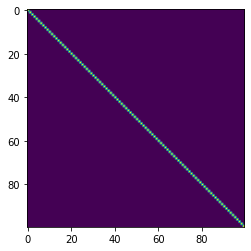

In [91]:
import seaborn as sns
p = prob.solution[k].solution.transport_matrix
p = np.array(prob.solution[k].solution.transport_matrix)
plt.imshow(p)

In [60]:
p = prob.solution[k].solution.transport_matrix
p = p / p.sum(1)[None, :]
p

DeviceArray([[1., 0., 0., ..., 0., 0., 0.],
             [0., 1., 0., ..., 0., 0., 0.],
             [0., 0., 1., ..., 0., 0., 0.],
             ...,
             [0., 0., 0., ..., 1., 0., 0.],
             [0., 0., 0., ..., 0., 1., 0.],
             [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [75]:
new = ad1.X.T @ prob.solution[k].solution.transport_matrix
new.shape

(500, 100)

In [76]:
pi = prob.solution[k].solution.transport_matrix

In [78]:
pi.argmax(1)

DeviceArray([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14,
             15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29,
             30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44,
             45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59,
             60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74,
             75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89,
             90, 91, 92, 93, 94, 95, 96, 97, 98, 99], dtype=int32)

In [ ]:
sc.pl.spatial(adata, basis="spatial_aligned", spot_size=0.5, color="batch")

In [4]:
adata_sp2 = adata_sp.copy()

In [5]:
sc.pp.subsample(adata_sc, fraction=0.05)
sc.pp.subsample(adata_sp, fraction=0.05)
sc.pp.subsample(adata_sp2, fraction=0.06)
print(adata_sc.shape, adata_sp.shape, adata_sp2.shape)

(670, 17135) (970, 351) (1164, 351)


In [6]:
# adata_sc.obs["batch"] = pd.Categorical(np.ones(adata_sc.shape[0]))
# adata_sp.obs["batch"] = pd.Categorical(np.ones(adata_sp.shape[0]))

In [7]:
adata_sp_joint = adata_sp.concatenate(adata_sp2, batch_key="batch")

In [15]:
adata_sc.obs["batch"] = 0

In [16]:
var_names = adata_sp_joint.var_names[0:10]

In [32]:
from moscot.problems.space._mapping import SpatialMappingProblem
from moscot.backends.ott import FGWSolver, SinkhornSolver, GWSolver

prob = SpatialMappingProblem(
    adata_sc=adata_sc, adata_sp=adata_sp_joint, var_names=var_names, use_reference=True
)
# prob

In [33]:
prob.prepare(key="batch")  # attr_sc =  {"attr": "obsm", "key": "X_scvi"})

In [34]:
prob._policy.plan()

{('0', <object at 0x7f58fcfdc2e0>): [('0', <object at 0x7f58fcfdc2e0>)],
 ('1', <object at 0x7f58fcfdc2e0>): [('1', <object at 0x7f58fcfdc2e0>)]}

In [35]:
prob.solve()

In [36]:
prob.solution

{('0',
  <object at 0x7f58fcfdc2e0>): <moscot.problems._base_problem.GeneralProblem at 0x7f597c3582e0>,
 ('1',
  <object at 0x7f58fcfdc2e0>): <moscot.problems._base_problem.GeneralProblem at 0x7f597c1f6af0>}

In [37]:
prob._policy._SENTINEL

In [38]:
temp = [t for t in prob.solution.values()]

In [39]:
temp[0].solution.transport_matrix.shape

(970, 670)

In [40]:
temp[1].solution.transport_matrix.shape

(1164, 670)

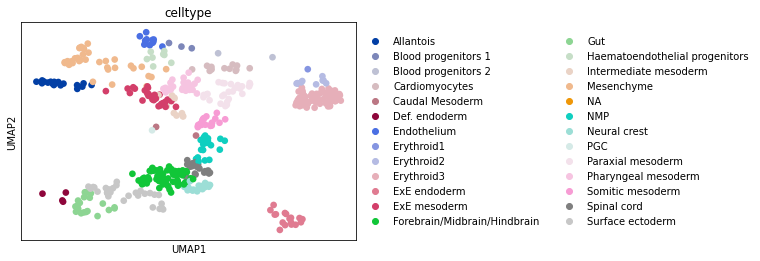

In [17]:
sc.pl.umap(adata_sc, color="celltype")

In [58]:
adata_sc.shape

(670, 17135)

In [59]:
adata_sc.shape

(670, 17135)

In [90]:
temp = [v for k, v in prob.solution.items()]

In [91]:
temp[0].solution.transport_matrix.shape

(670, 970)

In [77]:
adata_sp.shape

(970, 351)

In [45]:
prob._adata_sc

View of AnnData object with n_obs × n_vars = 670 × 10
    obs: 'cell', 'barcode', 'sample', 'pool', 'stage', 'sequencing.batch', 'theiler', 'doub.density', 'doublet', 'cluster', 'cluster.sub', 'cluster.stage', 'cluster.theiler', 'stripped', 'celltype', 'colour', 'sizeFactor', 'n_counts', '_scvi_batch', '_scvi_labels'
    var: 'ENSEMBL', 'SYMBOL', 'n_counts', 'overlap', 'marker', 'reference'
    uns: 'X_name', '_scvi', 'neighbors', 'umap'
    obsm: 'XY_cost', 'X_cost', 'X_scvi', 'X_umap', 'pca.corrected', 'umap'
    layers: 'ambiguous_counts', 'counts', 'spliced_counts', 'unspliced_counts'
    obsp: 'connectivities', 'distances'

In [ ]:
.prepare(sc_attr={'attr':'obsm', 'key':'X_scvi'},
                                                         sp_attr={'attr': 'obsm', 'key': 'spatial'},
                                                         atlas_attr={'sc_attr':'X', 'sp_attr':'X'},
                                                         keys_subset=marker_keys)

In [21]:
adata.obs.batch

0      0
1      0
2      0
3      0
4      0
      ..
195    1
196    1
197    1
198    1
199    1
Name: batch, Length: 200, dtype: int64

In [25]:
FGWSolver(gamma=0.1)

In [23]:
spap.prepare(key="batch")
# prepare("day", subset=[[1,2]], policy="sequential")

TypeError: __init__() missing 1 required positional argument: 'attr'